## Lotka-Volterra 1 predator 1 prey test

### Roe Deer and Wolf

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Roe deer and wolf
alpha1 = 9/11 # Birth rate prey 
beta1 = 48.6 / 365.25 # Death rate prey
gamma1 =  25/26 # Death rate predator
delta1 = 0.0356 # Grow rate predator

# Time * step = amount of years
time = 1000000
step1 = 0.0001

pred_name = 'wolf'
prey1_name = 'roe deer'

# Initial populations
init_pred = 10
init_prey1 = 110

# Differential equation predator population
def pred_eq(gamma, delta, w, r, step):
    return step * w * (-gamma + delta*r) 

# Differential equation prey population
def prey1_eq(alpha, beta, w, r, step):
    return step * r * (alpha - beta*w)

In [162]:
# Initialize arrays for number of animals in populations
pred = [init_pred]
prey1 = [init_prey1]

num_pred = init_pred
num_prey1 = init_prey1

# Update the number of animals time times and store them in arrays
for n in range(time):
    dpred = pred_eq(gamma1, delta1, num_pred, num_prey1, step1)
    dprey1 = prey1_eq(alpha1, beta1, num_pred, num_prey1, step1)
    num_pred += dpred
    num_prey1 += dprey1
    pred.append(num_pred)
    prey1.append(num_prey1)

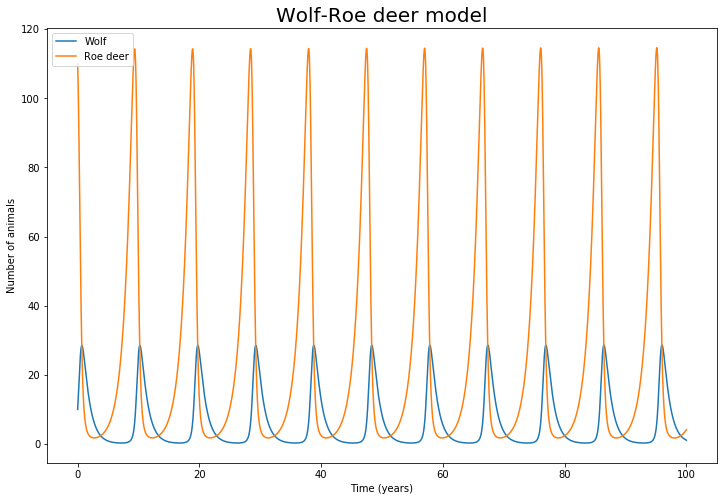

In [163]:
# Plot the figure
t = range(time+1)
t = [step*x for x in t]

plt.figure(figsize=(12,8))
plt.plot(t, pred)
plt.plot(t, prey1)
plt.ylabel('Number of animals')
plt.xlabel('Time (years)')
plt.title('Wolf-Roe deer model', fontsize=20)
plt.legend(['Wolf', 'Roe deer'], loc='upper left')
plt.show()

### Wild Boar and Wolf

In [164]:
# Wild boar and wolf
alpha2 = 6.22 # Birth rate prey 
beta2 = 12.4 / 182.75  # Death rate prey
gamma2 = 25/26 # Death rate predator
delta2 = 0.0356 # Grow rate predator

# Time * step = amount of years simulated
time2 = 1000000 
step2 = 0.0001

# Initial populations
init_pred2 = 1
init_prey2 = 500

In [165]:
pred2 = [init_pred2]
prey2 = [init_prey2]

num_pred2 = init_pred2
num_prey2 = init_prey2

for n in range(time):
    dpred2 = pred_eq(gamma2, delta2, num_pred2, num_prey2, step2)
    dprey2 = prey1_eq(alpha2, beta2, num_pred2, num_prey2, step2)
    num_pred2 += dpred2
    num_prey2 += dprey2
    pred2.append(num_pred2)
    prey2.append(num_prey2)

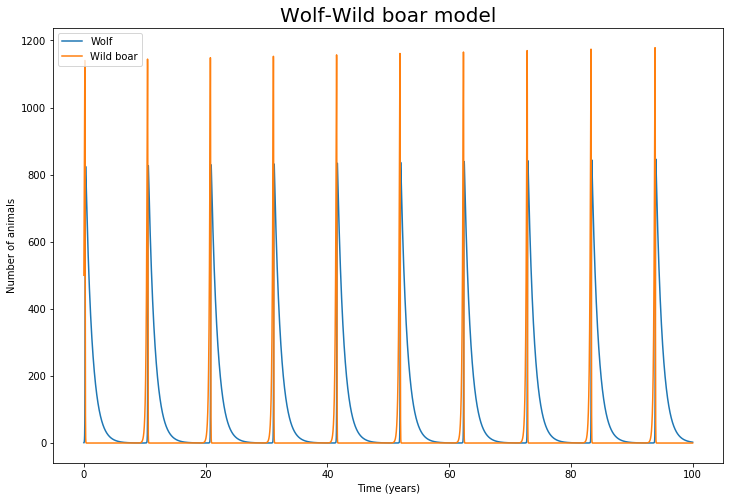

In [166]:
t2 = range(time2+1)
t2 = [step2*x for x in t2]

plt.figure(figsize=(12,8))
plt.plot(t2, pred2)
plt.plot(t2, prey2)
plt.ylabel('Number of animals')
plt.xlabel('Time (years)')
plt.title('Wolf-Wild boar model', fontsize=20)
plt.legend(['Wolf', 'Wild boar'], loc='upper left')
plt.show()

### Lotka-Volterra Vector Field (Stable Point Visualization) 

In [307]:
alpha3 = 9/11 # Birth rate prey 
beta3 = 48.6/365.25 # Death rate prey
gamma3 = 25/26 # Death rate predator
delta3 = 0.0356 # Grow rate predator

max_prey = 50 # Maximum begin population of prey
max_pred = 15 # Maximum begin population of predators

arrow_density = 2 # number of arrows per 1 unit

# Make a sample starting point
sample_pred = 7
sample_prey = 29
sample_length = 400
sample_step = 0.1
arrows = True
arrow_distance = 10

The stable point (besides (0,0)) is at 27.01 initial preys and 6.15 initial predators.
Predator difference (should be 0): 0.00
Prey difference (should be 0): 0.00


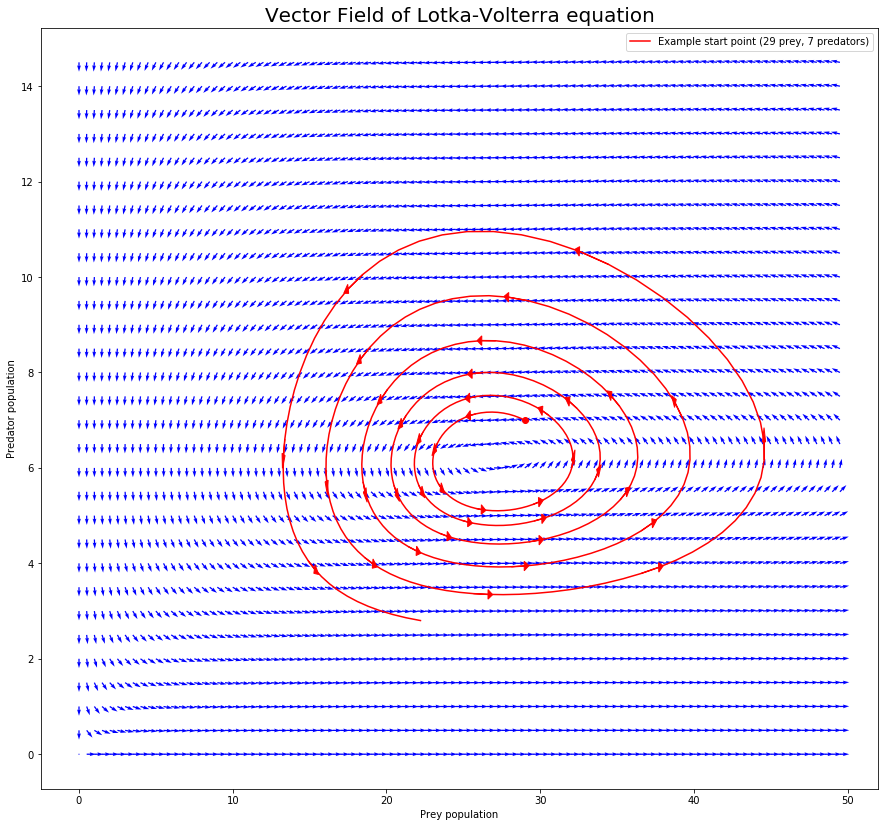

In [308]:
X, Y = np.meshgrid(np.arange(0, max_prey, 1/arrow_density), np.arange(0, max_pred, 1/arrow_density))

stable_pred = alpha3 / beta3 # Stable initial population of predators
stable_prey = gamma3 / delta3 # Stable initial population of prey
print('The stable point (besides (0,0)) is at %.2f initial preys and %.2f initial predators.' % (stable_prey, stable_pred))

# Check stability in formulas
print('Predator difference (should be 0): %.2f' % pred_eq(gamma3, delta3, stable_pred, stable_prey, 1))
print('Prey difference (should be 0): %.2f' % prey1_eq(alpha3, beta3, stable_pred, stable_prey, 1))

U = np.zeros(X.shape)
V = np.zeros(X.shape)

for r in range(max_prey * arrow_density):
    for c in range(max_pred * arrow_density):
        U[c][r] = prey1_eq(alpha3, beta3, c/arrow_density, r/arrow_density, 1) 
        V[c][r] = pred_eq(gamma3, delta3, c/arrow_density, r/arrow_density, 1) 
        norm = np.sqrt((U[c][r])**2 + (V[c][r])**2)
        if norm != 0:
            U[c][r] = U[c][r] / norm
            V[c][r] = V[c][r] / norm
    
s_prey = [sample_prey]
s_pred = [sample_pred]
for t in range(sample_length):
    cur_prey = s_prey[-1]
    cur_pred = s_pred[-1]
    s_prey.append(cur_prey + prey1_eq(alpha3, beta3, cur_pred, cur_prey, sample_step))
    s_pred.append(cur_pred + pred_eq(gamma3, delta3, cur_pred, cur_prey, sample_step))
    
plt.figure(figsize=(15,14))
plt.quiver(X, Y, U, V, scale=90, width=0.0015, color='b') # bigger scale is smaller arrows

# Draw the sample line
plt.plot(s_prey, s_pred, 'r-')

# Draw starting point as a dot
plt.plot(sample_prey, sample_pred, 'ro')

# Draw arrows in line 
if arrows:
    for i in range(9, sample_length, arrow_distance):
        if i+1 < sample_length:
            plt.arrow(s_prey[i], s_pred[i], s_prey[i+1]-s_prey[i], s_pred[i+1]-s_pred[i], color='r', head_width=0.2)

plt.legend(["Example start point (%d prey, %d predators)" % (sample_prey, sample_pred)])
plt.ylabel('Predator population')
plt.xlabel('Prey population')
plt.title('Vector Field of Lotka-Volterra equation', fontsize=20)
plt.show()